# <center>**Military Aircraft Detection Project using EfficientNetB3**<center>

## **Project Overview**

### ***This notebook details the complete workflow for building a deep learning model to classify military aircraft. The process involves:***
### ***1.  Loading a large dataset of 88 different aircraft types.***
### ***2.  Filtering the dataset to focus on a specific list of 40 classes.***
### ***3.  Creating a high-performance `tf.data` input pipeline to prevent CPU bottlenecks.***
### ***4.  Building and fine-tuning a pre-trained `EfficientNetB3` model.***
### ***5.  Training the model using robust callbacks for automatic stopping and learning rate adjustment.***
### ***6.  Evaluating the final model's performance on unseen test data.***
### ***7.  Saving the model and creating an interactive interface for real-time predictions.***

## <center>**Step 1: Code - Initial Setup & Helper Functions**<center>

In [1]:
# System and Utility Libraries
import os
import time
import shutil
import pathlib
import itertools

# Data Handling and Visualization
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Deep Learning Framework: TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

print('All modules have been successfully imported.')

2025-08-18 18:45:16.025269: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755542716.222569      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755542716.278072      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


All modules have been successfully imported.


## **<center>---- Helper Functions for Initial Data Loading ----<center>**

In [2]:
# Function to generate lists of file paths and their labels
def define_paths(dir):
    filepaths = []
    labels = []
    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    return filepaths, labels

# Function to create a DataFrame from file paths and labels
def define_df(files, classes):
    Fseries = pd.Series(files, name='filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis=1)

In [3]:
# Handles a single data directory, splitting it into train, validation, and test sets.
def full_data(data_dir):
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    strat = df['labels']
    # Split into 80% train and 20% temporary
    train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123, stratify=strat)
    # Split the temporary 20% into 10% validation and 10% test
    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=123, stratify=strat)
    return train_df, valid_df, test_df

# Handles separate train and test directories.
def tr_ts_data(tr_dir, ts_dir):
    # Create train and validation dataframes from the training directory
    files, classes = define_paths(tr_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, valid_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123, stratify=strat)
    # Create the test dataframe
    files, classes = define_paths(ts_dir)
    test_df = define_df(files, classes)
    return train_df, valid_df, test_df

# Handles pre-split train, validation, and test directories.
def tr_val_ts_data(tr_dir, val_dir, ts_dir):
    # Train dataframe
    files, classes = define_paths(tr_dir)
    train_df = define_df(files, classes)
    # Validation dataframe
    files, classes = define_paths(val_dir)
    valid_df = define_df(files, classes)
    # Test dataframe
    files, classes = define_paths(ts_dir)
    test_df = define_df(files, classes)
    return train_df, valid_df, test_df

# Main function to split data based on provided directories.
def split_data(tr_dir, val_dir=None, ts_dir=None):
    if val_dir == '' and ts_dir == '':
        return full_data(tr_dir)
    elif val_dir == '' and ts_dir != '':
        return tr_ts_data(tr_dir, ts_dir)
    elif val_dir != '' and ts_dir != '':
        return tr_val_ts_data(tr_dir, val_dir, ts_dir)

## **<center>Step 2: Load and Filter the Dataset</center>**
### ***First, we load the paths and labels from the entire 88-class dataset into pandas DataFrames. Then, we define a specific list of 40 classes we want to focus on and filter the DataFrames to include only data from these selected classes.***

In [4]:
# Provide the path to the full dataset directory
train_dir = '/kaggle/input/militaryaircraftdetectiondataset/crop'

# Load the initial DataFrames from the full 88-class dataset
train_df, valid_df, test_df = full_data(train_dir)
print(f"Successfully loaded dataframes with {train_df['labels'].nunique()} classes.")

# --- FILTERING STEP ---
# Define the list of the 40 classes you want to keep.
selected_classes = [
    'F16', 'B52', 'C130', 'A10', 'Tejas', 'F22', 'F35', 'Su24',
    'Il76', 'J10', 'TB2', 'UH60', 'F14', 'F4', 'Tornado', 'F15', 'J50',
    'Mi8', 'KAAN', 'Vulcan', 'MQ9', 'Mi28', 'B2', 'B1', 'An72',
    'Mi26', 'CH53', 'Mig31', 'AH64', 'C390', 'C17', 'JF17', 'Mig29',
    'Su57', 'SR71', 'Mirage2000', 'Su34', 'Mi24', 'Rafale', 'J35'
]

# Filter the dataframes to only include rows with the selected classes.
train_df_filtered = train_df[train_df['labels'].isin(selected_classes)].copy()
valid_df_filtered = valid_df[valid_df['labels'].isin(selected_classes)].copy()
test_df_filtered = test_df[test_df['labels'].isin(selected_classes)].copy()

# Verify the result. The number of classes should now be 40.
print(f"\n--- After Filtering ---")
print(f"New number of classes in training set: {train_df_filtered['labels'].nunique()}")
print(f"Filtered training images: {len(train_df_filtered)}")

Successfully loaded dataframes with 88 classes.

--- After Filtering ---
New number of classes in training set: 40
Filtered training images: 16578


## **<center>Step 3: Create High-Performance `tf.data` Pipeline</center>**
### ***To ensure the GPU is never waiting for data, we convert the pandas DataFrames into a `tf.data.Dataset`. This modern pipeline uses parallel processing, caching, and prefetching to deliver data to the model with maximum efficiency, solving any potential CPU bottlenecks.***

In [5]:
# Define key parameters
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
AUTOTUNE = tf.data.AUTOTUNE

# Get the file paths and labels from dataframe
train_paths = train_df_filtered['filepaths'].values
train_labels = train_df_filtered['labels'].values
valid_paths = valid_df_filtered['filepaths'].values
valid_labels = valid_df_filtered['labels'].values
test_paths = test_df_filtered['filepaths'].values
test_labels = test_df_filtered['labels'].values

# Create a dictionary to map class names (strings) to integer indices
class_names = sorted(list(set(train_labels)))
label_to_index = {name: i for i, name in enumerate(class_names)}
index_to_label = {i: name for i, name in enumerate(class_names)} # Good to have for later

# Convert string labels to integer indices
train_labels_int = [label_to_index[label] for label in train_labels]
valid_labels_int = [label_to_index[label] for label in valid_labels]
test_labels_int = [label_to_index[label] for label in test_labels]

def process_path(file_path, label):
    """Loads and preprocesses a single image."""
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    # Decode the image
    img = tf.io.decode_jpeg(img, channels=3)
    # Resize the image
    img = tf.image.resize(img, IMG_SIZE)
    # Convert label to one-hot encoding
    label = tf.one_hot(label, len(class_names))
    return img, label

def configure_for_performance(dataset, shuffle=False):
    """Applies performance optimizations to a tf.data.Dataset."""
    # Cache the dataset in memory to avoid re-reading from disk every epoch
    dataset = dataset.cache()
    if shuffle:
        # Shuffle the data
        dataset = dataset.shuffle(buffer_size=1000)
    # Batch the data
    dataset = dataset.batch(BATCH_SIZE)
    # Prefetch the next batch while the GPU is working on the current one
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    return dataset

# Create the datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels_int))
valid_ds = tf.data.Dataset.from_tensor_slices((valid_paths, valid_labels_int))
test_ds = tf.data.Dataset.from_tensor_slices((test_paths, test_labels_int))

# Apply the preprocessing and performance optimizations
# Use num_parallel_calls to use multiple CPU cores at once
train_gen = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
valid_gen = valid_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_gen = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)

# Configure for performance
train_gen = configure_for_performance(train_gen, shuffle=True)
valid_gen = configure_for_performance(valid_gen)
test_gen = configure_for_performance(test_gen)

print("High-performance tf.data pipelines created successfully.")

I0000 00:00:1755542739.750985      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


High-performance tf.data pipelines created successfully.


## **<center>Step 4: Create functions for Data Visualization</center>**
### ***Before training the model, it is crucial to visually inspect the data. This helps in understanding the distribution of classes and verifying that the images are correctly labeled. We will create dedicated functions to visualize two key aspects: a bar chart showing the number of images per aircraft class, and a grid displaying a sample of the images from our dataset.***

In [6]:
# Function to display a sample of images from the tf.data generator
def show_images(gen):
    # Get a single batch of images and labels
    # .as_numpy_iterator() converts the TensorFlow tensors to NumPy arrays
    images, labels = next(gen.as_numpy_iterator())

    plt.figure(figsize=(20, 20))

    for i in range(min(len(labels), 25)):
        plt.subplot(5, 5, i + 1)
        image = images[i].astype('uint8')
        plt.imshow(image)

        index = np.argmax(labels[i])
        class_name = index_to_label[index]

        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()

# Function to plot the distribution of classes
def plot_label_count(df, plot_title):
    vcounts = df['labels'].value_counts()
    labels = vcounts.keys().tolist()
    values = vcounts.tolist()

    plt.figure(figsize=(min(len(labels) * 1, 20), 6))
    sns.barplot(x=labels, y=values)
    plt.title(f'Images per Label in {plot_title} data', fontsize=18)
    plt.xticks(rotation=90)
    plt.xlabel('Class')
    plt.ylabel('Image Count')
    plt.show()

## **<center>---- Data Visualization ----</center>**

Displaying class distribution for the filtered training data...


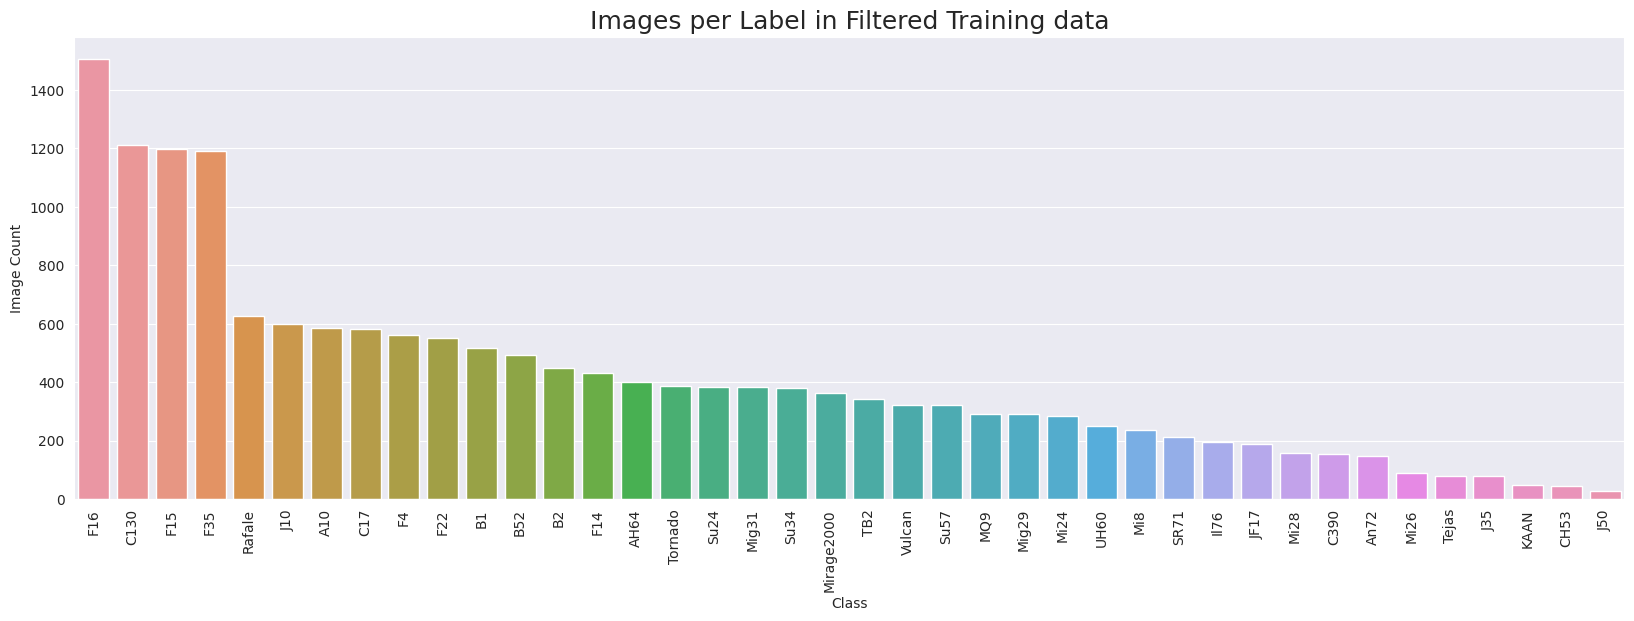


Displaying a sample of images from the training generator...


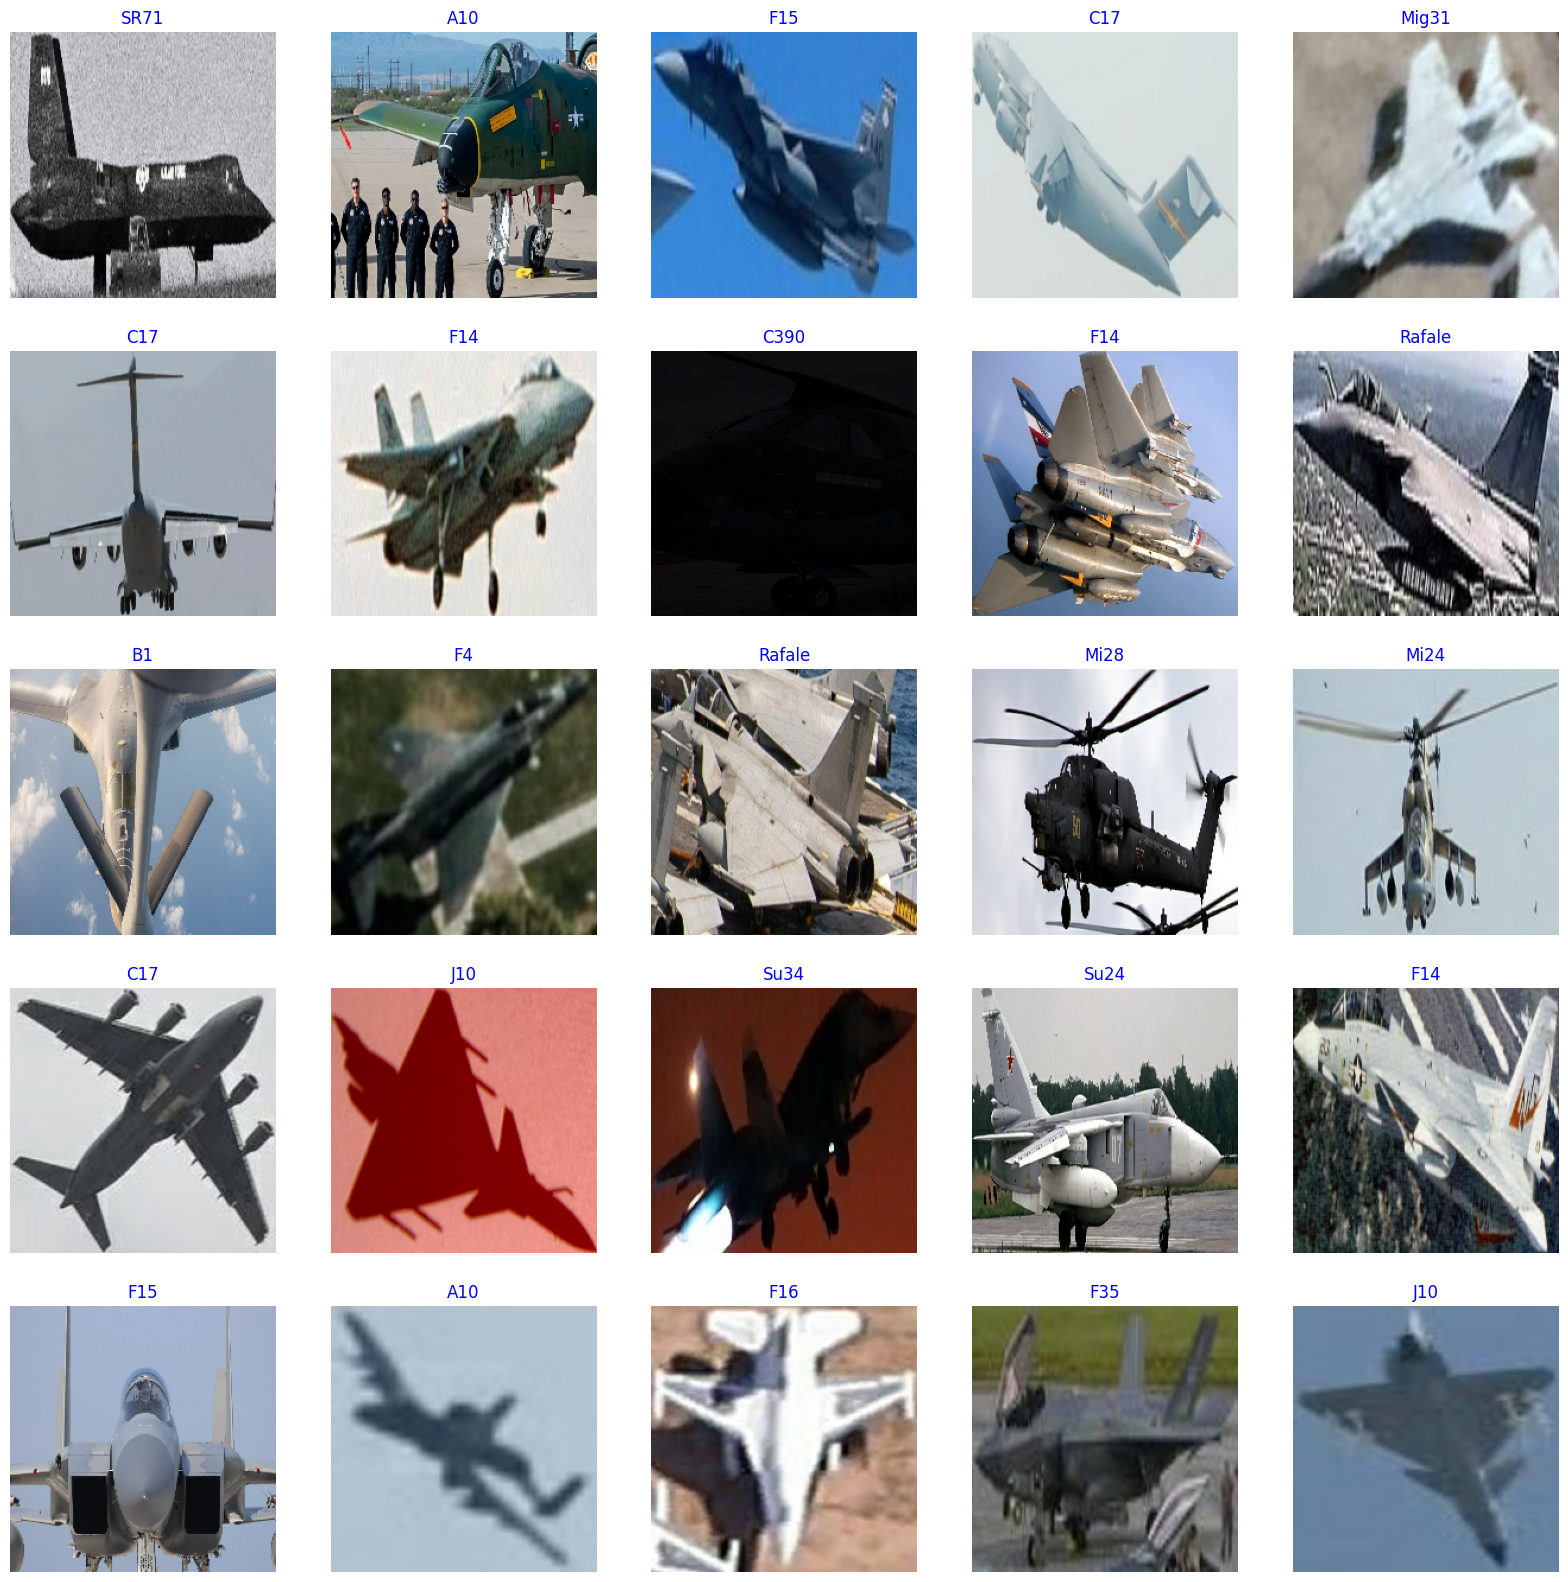

In [7]:
# 1. Plot the distribution of the 40 classes
print("Displaying class distribution for the filtered training data...")
plot_label_count(train_df_filtered, 'Filtered Training')

# 2. Show a sample of images
print("\nDisplaying a sample of images from the training generator...")
show_images(train_gen)

## **<center>Step 5: Define and Train with a Custom Advanced Callback</center>**
### ***This cell contains a comprehensive, custom Keras callback called `MyCallback` designed to provide advanced control and monitoring over the model's training process. Instead of using several separate callbacks, this single class consolidates multiple functionalities to create a highly adaptive training loop.***

In [8]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.patience = patience
        self.stop_patience = stop_patience
        self.threshold = threshold
        self.factor = factor
        self.batches = batches
        self.epochs = epochs
        self.ask_epoch = ask_epoch # For the halt feature

        # Callback variables
        self.count = 0
        self.stop_count = 0
        self.best_epoch = 1
        self.highest_tracc = 0.0
        self.lowest_vloss = np.inf

    def on_train_begin(self, logs=None):
        self.initial_lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        self.best_weights = self.model.get_weights()
        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()

    def on_epoch_begin(self, epoch, logs=None):
        self.ep_start = time.time()

    def on_epoch_end(self, epoch, logs=None):
        ep_end = time.time()
        duration = ep_end - self.ep_start
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        current_lr = lr
        acc = logs.get('accuracy')
        v_acc = logs.get('val_accuracy')
        loss = logs.get('loss')
        v_loss = logs.get('val_loss')

        # --- Learning Rate Logic ---
        if acc < self.threshold:
            monitor = 'accuracy'
            pimprov = (acc - self.highest_tracc) * 100 / self.highest_tracc if epoch > 0 and self.highest_tracc != 0 else 0.0
            if acc > self.highest_tracc:
                self.highest_tracc = acc
                self.best_weights = self.model.get_weights()
                self.count = 0
                self.stop_count = 0
                self.best_epoch = epoch + 1
            else:
                if self.count >= self.patience - 1:
                    lr *= self.factor
                    # CORRECTED LINE: Use .assign() instead of tf.keras.backend.set_value()
                    self.model.optimizer.learning_rate.assign(lr)
                    self.stop_count += 1
                    self.count = 0
                else:
                    self.count += 1
        else:
            monitor = 'val_loss'
            pimprov = (self.lowest_vloss - v_loss) * 100 / self.lowest_vloss if epoch > 0 and self.lowest_vloss != np.inf else 0.0
            if v_loss < self.lowest_vloss:
                self.lowest_vloss = v_loss
                self.best_weights = self.model.get_weights()
                self.count = 0
                self.stop_count = 0
                self.best_epoch = epoch + 1
            else:
                if self.count >= self.patience - 1:
                    lr *= self.factor
                    self.stop_count += 1
                    self.count = 0
                    # CORRECTED LINE: Use .assign() instead of tf.keras.backend.set_value()
                    self.model.optimizer.learning_rate.assign(lr)
                else:
                    self.count += 1

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1:
            print(f"\nTraining halted: stop patience ({self.stop_patience}) reached.")
            self.model.stop_training = True

        # --- Interactive Halt Logic ---
        if (epoch + 1) >= self.ask_epoch:
            try:
                print(f"\n--- Epoch {epoch + 1} finished. ---")
                ans = input("Enter 'H' to halt, or an integer for how many more epochs to run before asking again: ")
                if ans.lower() == 'h':
                    print("Halting training as requested.")
                    self.model.stop_training = True
                else:
                    self.ask_epoch += int(ans)
                    print(f"Training will continue. Next check will be after epoch {self.ask_epoch}.")
            except (ValueError, TypeError):
                print("Invalid input. Continuing training...")

    def on_train_end(self, logs=None):
        self.model.set_weights(self.best_weights)

## **<center>Step 6: Post-Training Evaluation and Visualization Functions</center>**
### ***After the model has finished training, it's crucial to evaluate its performance in detail. This cell defines two essential helper functions for visualizing the results. These functions will help us understand both the overall learning process and the specific class-by-class performance of our model.***

* ### **`plot_training(hist)`**: ***This function takes the `hist` object returned by the `model.fit()` command and creates two side-by-side plots. These plots show the model's accuracy and loss for both the training and validation datasets over each epoch. This visualization is key to diagnosing the health of the training process and identifying signs of overfitting.***

* ### **`plot_confusion_matrix(...)`**: ***This function generates a visual heatmap of the model's predictions on the test set. The confusion matrix provides a much deeper insight than a single accuracy score, as it shows exactly which classes the model is correctly identifying and which ones it is confusing with others. The diagonal of the matrix represents correct predictions, while off-diagonal values highlight specific prediction errors.***

In [9]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    
    Epochs = [i+1 for i in range(len(tr_acc))]
    
    plt.figure(figsize=(20, 8))
    
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label='Training loss')
    plt.plot(Epochs, val_loss, 'g', label='Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=f'Best epoch = {index_loss+1}')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
    plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=f'Best epoch = {index_acc+1}')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## **<center>Step 7: Build and Fine-Tune the Model Architecture</center>**
### ***This cell constructs the core of our project: the deep learning model. We leverage a powerful technique called transfer learning by using a pre-trained model, which allows us to benefit from knowledge gained on a massive dataset (ImageNet) and adapt it to our specific aircraft classification task.***

In [10]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

# Define the input shape and number of classes from filtered data
IMG_SHAPE = (IMG_SIZE[0], IMG_SIZE[1], 3)
CLASS_COUNT = len(class_names)

# 1. Load the base model and freeze it
base_model = EfficientNetB3(include_top=False, weights="imagenet", input_shape=IMG_SHAPE, pooling='max')
base_model.trainable = False # Freeze all layers initially

# 2. Build the full model
model = Sequential([
    base_model,
    BatchNormalization(axis=-1),
    Dense(512, kernel_regularizer=regularizers.l2(0.01), activation='relu'),
    Dropout(rate=0.4),
    Dense(CLASS_COUNT, activation='softmax') # Output layer
])

# 3. Unfreeze the top layers for fine-tuning
fine_tune_at = -30
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

# 4. Compile the model for fine-tuning with a low learning rate
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print(f"Model compiled for {CLASS_COUNT} classes.")
model.summary()

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model compiled for 40 classes.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 1536)           │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 40)             │        20,520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,597,143 (44.24 MB)

 Trainable params: 4,361,922 (16.64 MB)

 Non-trainable params: 7,235,221 (27.60 MB)

## **<center>Step 8: Configure and Execute Model Training</center>**
### ***This cell serves as the control panel for our model's training process. We first define a set of parameters that will govern the behavior of our custom `MyCallback`. This allows for a highly adaptive and controlled training loop. After setting these parameters, we launch the training using the `model.fit()` command.***

In [11]:
# Define parameters for the custom callback
patience = 1
stop_patience = 3
threshold = 0.9
factor = 0.5
batches = len(train_gen)
epochs = 40
ask_epoch = 5

callbacks_list = [MyCallback(patience=patience, stop_patience=stop_patience,
                           threshold=threshold, factor=factor, batches=batches,
                           epochs=epochs, ask_epoch=ask_epoch)]

# Train the model
history = model.fit(train_gen,
                    verbose=0,
                    epochs=epochs,
                    validation_data=valid_gen,
                    callbacks=callbacks_list)

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration


I0000 00:00:1755542791.818351      93 service.cc:148] XLA service 0x7f61b01864c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755542791.819197      93 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1755542795.945317      93 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1755542802.690011      93 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755542802.909133      93 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755542803.574218      93 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755542803.8388

 1 /40     9.803   26.095   7.93827  51.280   0.00010  0.00010  accuracy     0.00    182.55 
 2 /40     7.156   52.932   6.18811  63.641   0.00010  0.00010  accuracy    102.84   35.11  
 3 /40     5.506   65.322   4.91381  67.890   0.00010  0.00010  accuracy    23.41    34.95  
 4 /40     4.237   73.459   3.90405  71.511   0.00010  0.00010  accuracy    12.46    34.38  
 5 /40     3.243   79.370   3.11217  73.636   0.00010  0.00010  accuracy     8.05    34.92  

--- Epoch 5 finished. ---


Enter 'H' to halt, or an integer for how many more epochs to run before asking again:  10


Training will continue. Next check will be after epoch 15.
 6 /40     2.484   83.557   2.50829  75.085   0.00010  0.00010  accuracy     5.27    34.29  
 7 /40     1.909   87.079   2.07073  76.099   0.00010  0.00010  accuracy     4.22    35.04  
 8 /40     1.473   89.685   1.73324  77.306   0.00010  0.00010  accuracy     2.99    34.60  
 9 /40     1.154   91.724   1.51139  77.161   0.00010  0.00010  val_loss     0.00    34.38  
10 /40     0.911   93.027   1.34245  77.451   0.00010  0.00010  val_loss    11.18    35.10  
11 /40     0.746   93.968   1.20741  78.223   0.00010  0.00010  val_loss    10.06    34.61  
12 /40     0.622   94.794   1.12311  78.658   0.00010  0.00010  val_loss     6.98    34.77  
13 /40     0.529   95.150   1.05236  79.237   0.00010  0.00010  val_loss     6.30    35.03  
14 /40     0.458   96.013   1.01343  79.817   0.00010  0.00010  val_loss     3.70    34.47  
15 /40     0.418   96.339   0.98516  79.285   0.00010  0.00010  val_loss     2.79    35.11  

--- Epoch 

Enter 'H' to halt, or an integer for how many more epochs to run before asking again:  10


Training will continue. Next check will be after epoch 25.
16 /40     0.389   96.357   0.94674  80.299   0.00010  0.00010  val_loss     3.90    34.61  
17 /40     0.351   96.797   0.92937  80.396   0.00010  0.00010  val_loss     1.83    34.88  
18 /40     0.329   96.863   0.92909  79.623   0.00010  0.00010  val_loss     0.03    34.50  
19 /40     0.319   96.972   0.91201  80.396   0.00010  0.00010  val_loss     1.84    34.40  
20 /40     0.287   97.394   0.89714  80.396   0.00010  0.00010  val_loss     1.63    35.08  
21 /40     0.286   97.364   0.90048  80.348   0.00010  0.00005  val_loss    -0.37    34.50  
22 /40     0.249   98.106   0.86161  81.217   0.00005  0.00005  val_loss     3.96    34.59  
23 /40     0.236   98.239   0.84683  81.362   0.00005  0.00005  val_loss     1.72    34.46  
24 /40     0.220   98.377   0.82822  81.217   0.00005  0.00005  val_loss     2.20    34.56  
25 /40     0.211   98.420   0.82548  81.555   0.00005  0.00005  val_loss     0.33    34.46  

--- Epoch 

Enter 'H' to halt, or an integer for how many more epochs to run before asking again:  10


Training will continue. Next check will be after epoch 35.
26 /40     0.206   98.486   0.82158  81.845   0.00005  0.00005  val_loss     0.47    34.50  
27 /40     0.196   98.552   0.80780  82.038   0.00005  0.00005  val_loss     1.68    34.71  
28 /40     0.186   98.570   0.81097  80.879   0.00005  0.00002  val_loss    -0.39    35.03  
29 /40     0.181   98.667   0.80214  81.458   0.00002  0.00002  val_loss     0.70    34.55  
30 /40     0.173   98.794   0.79908  81.700   0.00002  0.00002  val_loss     0.38    34.68  
31 /40     0.168   98.908   0.78525  82.424   0.00002  0.00002  val_loss     1.73    34.44  
32 /40     0.161   98.999   0.78319  82.279   0.00002  0.00002  val_loss     0.26    34.45  
33 /40     0.158   99.005   0.77370  82.183   0.00002  0.00002  val_loss     1.21    34.40  
34 /40     0.152   99.023   0.77016  82.327   0.00002  0.00002  val_loss     0.46    34.44  
35 /40     0.149   98.956   0.76642  82.183   0.00002  0.00002  val_loss     0.49    34.36  

--- Epoch 

Enter 'H' to halt, or an integer for how many more epochs to run before asking again:  5


Training will continue. Next check will be after epoch 40.
36 /40     0.148   99.107   0.76604  81.748   0.00002  0.00002  val_loss     0.05    34.36  
37 /40     0.145   98.999   0.76043  82.424   0.00002  0.00002  val_loss     0.73    34.44  
38 /40     0.141   99.119   0.75205  82.038   0.00002  0.00002  val_loss     1.10    34.27  
39 /40     0.140   99.011   0.74970  82.279   0.00002  0.00002  val_loss     0.31    34.27  
40 /40     0.139   98.962   0.74953  82.279   0.00002  0.00002  val_loss     0.02    34.23  

--- Epoch 40 finished. ---


Enter 'H' to halt, or an integer for how many more epochs to run before asking again:  h


Halting training as requested.


## <center>**Step 9: Evaluate Model Performance**</center>
### ***This cell provides a comprehensive and multi-faceted evaluation of the trained model's performance. Once training is complete, it's not enough to know the final accuracy; we need to understand how and where the model succeeds or fails. This is achieved through four key analyses:***

## **1. Training History Visualization** 
### ***The first step is to plot the training and validation accuracy/loss curves from the entire training run. These graphs are crucial for visually diagnosing the model's learning behavior and identifying the extent of overfitting.***

Displaying training history...


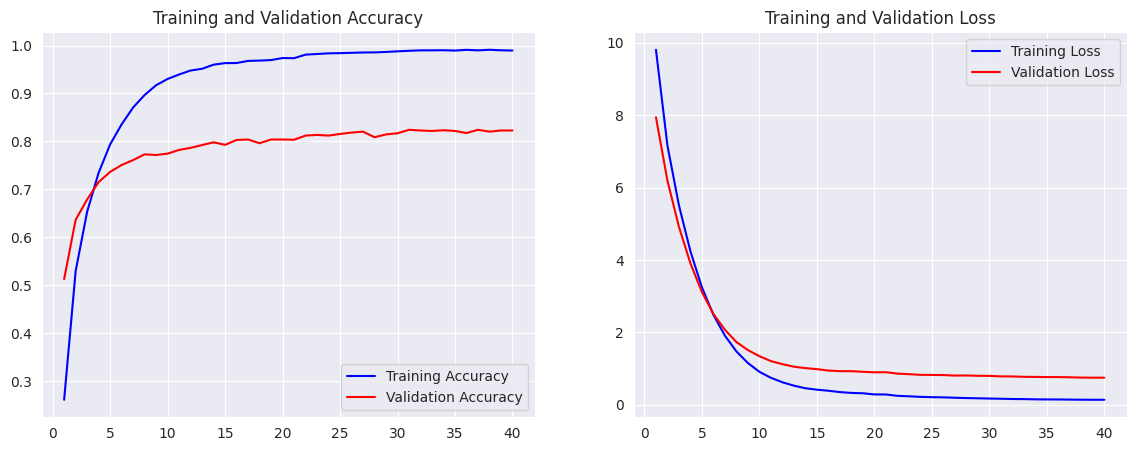

In [12]:
# 1. Plot the training history to visualize learning progress
def plot_training(hist):
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

print("Displaying training history...")
plot_training(history)

## **2. Final Test Score:** 
### ***We then use the `model.evaluate()` function on the completely unseen test dataset (`test_gen`). This provides the most important, unbiased metric of the model's real-world performance: the final test accuracy.***

In [13]:
# 2. Evaluate the model on the unseen test set for a final score
print("\nEvaluating model on the test set...")
loss, accuracy = model.evaluate(test_gen, verbose=1)
print(f"Final Test Accuracy: {accuracy * 100:.2f}%")
print(f"Final Test Loss: {loss:.4f}")


Evaluating model on the test set...
65/65 ━━━━━━━━━━━━━━━━━━━━ 15s 233ms/step - accuracy: 0.8438 - loss: 0.6671
Final Test Accuracy: 84.86%
Final Test Loss: 0.6689


## **3. Classification Report:** 
### ***To get a deeper insight, we generate a detailed report that shows the `precision`, `recall`, and `F1-score` for each of the 40 aircraft classes. This allows us to see if the model is particularly strong or weak at identifying specific types of aircraft.***

In [14]:
# 3. Generate a detailed Classification Report and Confusion Matrix
# Get model predictions
y_pred_probs = model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get the true labels from the test generator
y_true = np.concatenate([y for x, y in test_gen], axis=0)
y_true = np.argmax(y_true, axis=1)

# Print Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

65/65 ━━━━━━━━━━━━━━━━━━━━ 25s 221ms/step

Classification Report:
              precision    recall  f1-score   support

         A10       0.91      0.88      0.90        73
        AH64       0.80      0.86      0.83        50
        An72       1.00      0.78      0.88        18
          B1       0.91      0.89      0.90        65
          B2       0.82      0.88      0.84        56
         B52       0.91      0.95      0.93        62
        C130       0.92      0.94      0.93       152
         C17       0.81      0.85      0.83        73
        C390       0.79      0.79      0.79        19
        CH53       1.00      0.17      0.29         6
         F14       0.78      0.83      0.80        54
         F15       0.81      0.88      0.84       150
         F16       0.79      0.82      0.80       188
         F22       0.82      0.78      0.80        69
         F35       0.79      0.88      0.83       149
          F4       0.84      0.76      0.80        70
        Il76   

## **4. Confusion Matrix:** 
### ***Finally, we plot a confusion matrix. This is a powerful visualization that shows exactly where the model is making mistakes. Each cell in the grid shows how many images of a certain true class were predicted as another class, helping us identify specific confusion patterns (e.g., the model frequently confusing two similar-looking jets).***

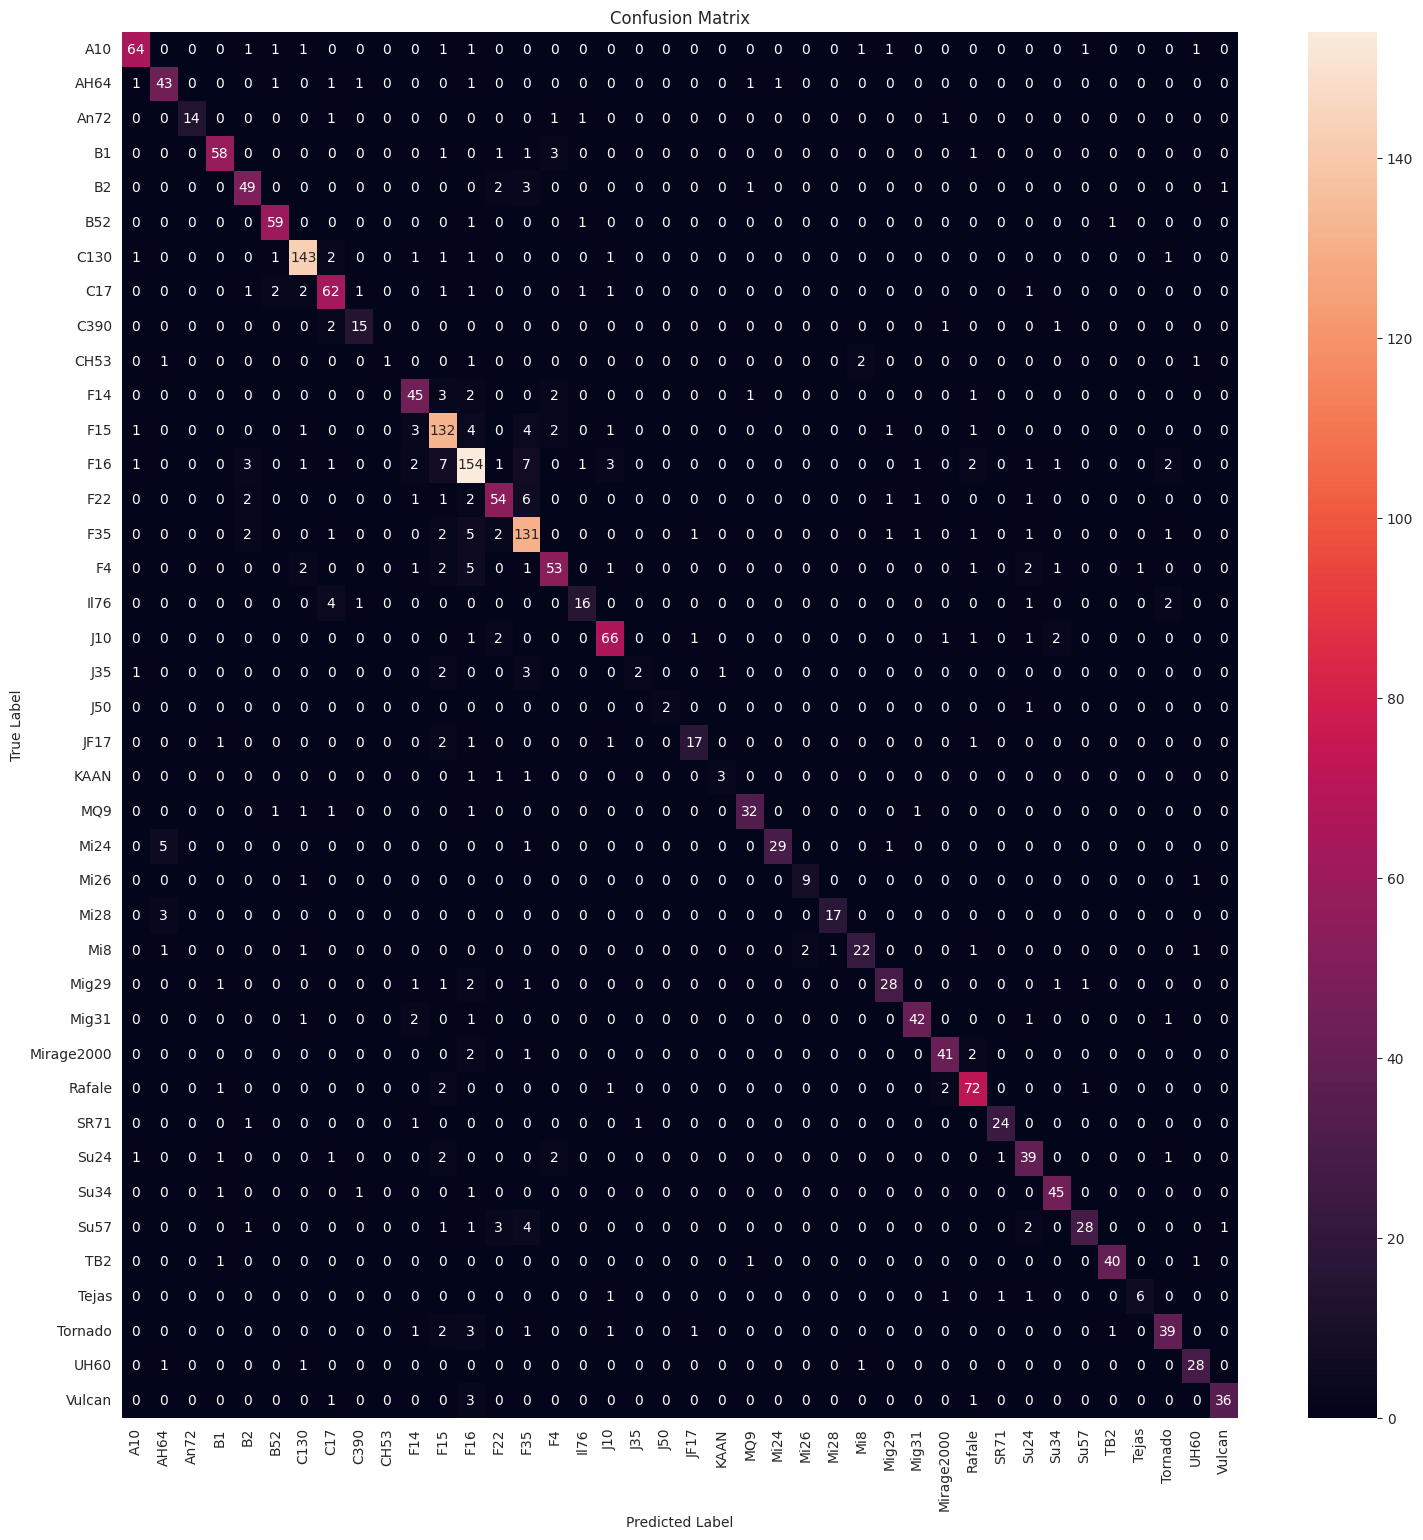

In [15]:
# Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(18, 18))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [16]:
# --- SAVE MODEL CELL ---
import json

# 1. Save the trained Keras model
model_filename = 'Aircraft_detector_model_final.h5'
model.save(model_filename)
print(f"Model saved successfully as '{model_filename}'")

# 2. Save the class dictionary (label_to_index) as a JSON file
class_indices_filename = 'class_indices.json'
with open(class_indices_filename, 'w') as f:
    json.dump(label_to_index, f)

print(f"Class indices saved successfully as '{class_indices_filename}'")

Model saved successfully as 'Aircraft_detector_model_final.h5'
Class indices saved successfully as 'class_indices.json'
